In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor
from matplotlib import pyplot
import shap
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
import gc
import json
pd.set_option('display.max_columns', 1000)

/kaggle/input/data-science-bowl-2019/train_labels.csv
/kaggle/input/data-science-bowl-2019/test.csv
/kaggle/input/data-science-bowl-2019/sample_submission.csv
/kaggle/input/data-science-bowl-2019/train.csv
/kaggle/input/data-science-bowl-2019/specs.csv


In [2]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [3]:
def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

In [4]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv')
    #train = pd.read_csv('train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv('/kaggle/input/data-science-bowl-2019/specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv('/kaggle/input/data-science-bowl-2019/sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

In [5]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

In [6]:
# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
        
    # last features
    sessions_count = 0
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
                    
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            features['installation_session_count'] = sessions_count
            
            variety_features = [('var_event_code', event_code_count),
                              ('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count)]
            
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
                 
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        sessions_count += 1
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [7]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

In [8]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.cv = self.get_cv()
        self.verbose = verbose
        self.params = self.get_params()
        self.y_pred, self.score, self.model = self.fit()
    
    def export_model(self):
        return self.model 
    
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(reduce_train), ))
        y_pred = np.zeros((len(reduce_test), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = eval_qwk_lgb_regr(self.train_df[self.target], oof_pred)
        if self.verbose:
            print('Our oof cohen kappa score is: ', loss_score)
        return y_pred, loss_score, model

In [9]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100
                    }
        return params

In [10]:
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(self.params, train_set, 
                         num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], 
                         verbose_eval=verbosity, early_stopping_rounds=100)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)
        
    def get_params(self):
        params = {'base_score':'0.5', 'booster':'gbtree','colsample_bylevel':'1','colsample_bynode':'1',
                  'colsample_bytree':'0.8','gamma':'0.25','learning_rate':'0.01','max_delta_step':'0',
                  'max_depth':'10','min_child_weight':'6','n_estimators':'200','n_jobs':'1',
                  'objective':'multi:softmax','random_state':'0','reg_alpha':'0', 'reg_lambda':'1',
                  'scale_pos_weight':'1','subsample':'1','verbosity':'1','num_class':4}
        return params

In [11]:
class Catb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        clf = CatBoostRegressor(**self.params)
        clf.fit(train_set['X'], 
                train_set['y'], 
                eval_set=(val_set['X'], val_set['y']),
                verbose=verbosity, 
                cat_features=self.categoricals)
        return clf
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        params = {'loss_function': 'RMSE',
                   'task_type': "CPU",
                   'iterations': 200,
                   'od_type': "Iter",
                    'depth': 10,
                  'colsample_bylevel': 0.5, 
                   'early_stopping_rounds': 100,
                    'l2_leaf_reg': 18,
                   'random_seed': 42,
                    'use_best_model': True
                    }
        return params

In [12]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

class Nn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.active_features_]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        print(train_df[features].shape)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(train_set['X'].shape[1],)),
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(50, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(25, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='relu')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

In [13]:
from random import choice

class Cnn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.active_features_]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        self.create_feat_2d(features)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def create_feat_2d(self, features, n_feats_repeat=50):
        self.n_feats = len(features)
        self.n_feats_repeat = n_feats_repeat
        self.mask = np.zeros((self.n_feats_repeat, self.n_feats), dtype=np.int32)
        for i in range(self.n_feats_repeat):
            l = list(range(self.n_feats))
            for j in range(self.n_feats):
                c = l.pop(choice(range(len(l))))
                self.mask[i, j] = c
        self.mask = tf.convert_to_tensor(self.mask)
        print(self.mask.shape)
       
        
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0

        inp = tf.keras.layers.Input(shape=(self.n_feats))
        x = tf.keras.layers.Lambda(lambda x: tf.gather(x, self.mask, axis=1))(inp)
        x = tf.keras.layers.Reshape((self.n_feats_repeat, self.n_feats, 1))(x)
        x = tf.keras.layers.Conv2D(18, (50, 50), strides=50, activation='relu')(x)
        x = tf.keras.layers.Flatten()(x)
        #x = tf.keras.layers.Dense(200, activation='relu')(x)
        #x = tf.keras.layers.LayerNormalization()(x)
        #x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(100, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(50, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        out = tf.keras.layers.Dense(1)(x)
        
        model = tf.keras.Model(inp, out)
    
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

In [14]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
#rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
                      max_features=3, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=8,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
# Train the model on training data
#rf.fit(train_features, train_labels)

In [15]:
# read data
train, test, train_labels, specs, sample_submission = read_data()

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


In [16]:
# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)

In [17]:
# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = get_train_and_test(train, test)

100%|██████████| 1000/1000 [00:46<00:00, 21.68it/s]


0.0026939774600629332


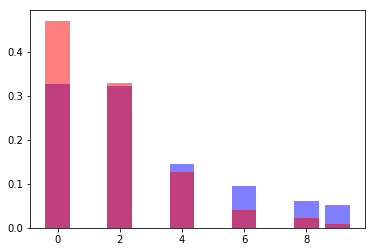

0.0026939774600629332

In [18]:
def stract_hists(feature, train=reduce_train, test=reduce_test, adjust=False, plot=False):
    n_bins = 10
    train_data = train[feature]
    test_data = test[feature]
    if adjust:
        test_data *= train_data.mean() / test_data.mean()
    perc_90 = np.percentile(train_data, 95)
    train_data = np.clip(train_data, 0, perc_90)
    test_data = np.clip(test_data, 0, perc_90)
    train_hist = np.histogram(train_data, bins=n_bins)[0] / len(train_data)
    test_hist = np.histogram(test_data, bins=n_bins)[0] / len(test_data)
    msre = mean_squared_error(train_hist, test_hist)
    if plot:
        print(msre)
        plt.bar(range(n_bins), train_hist, color='blue', alpha=0.5)
        plt.bar(range(n_bins), test_hist, color='red', alpha=0.5)
        plt.show()
    return msre
stract_hists('Magma Peak - Level 1_2000', adjust=False, plot=True)

In [19]:
# call feature engineering function
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]

In [20]:
counter = 0
to_remove = []
for feat_a in features:
    for feat_b in features:
        if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
            c = np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1]
            if c > 0.995:
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

1: FEAT_A: Clip FEAT_B: 27253bdc - Correlation: 0.9999999999999999
2: FEAT_A: 2050 FEAT_B: 2040 - Correlation: 0.9965259434878118
3: FEAT_A: 2050 FEAT_B: 73757a5e - Correlation: 0.9998050146713992
4: FEAT_A: 2050 FEAT_B: 37c53127 - Correlation: 1.0
5: FEAT_A: 2050 FEAT_B: 08fd73f3 - Correlation: 0.9966123918733654
6: FEAT_A: 2050 FEAT_B: dcaede90 - Correlation: 0.9965259434878118
7: FEAT_A: 2050 FEAT_B: 2b9272f4 - Correlation: 0.9999839030068793
8: FEAT_A: 2050 FEAT_B: 26fd2d99 - Correlation: 0.9965084543995759
9: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2050 - Correlation: 1.0
10: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2020 - Correlation: 0.9965084543995759
11: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2030 - Correlation: 0.9966123918733654
12: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3121 - Correlation: 0.9999839030068793
13: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2040 - Correlation: 0.9965259434878118
14: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3021 - Correlation: 0.9998050146713992
15: FEAT_A: 4230 FEAT_B: 4235 - Correlation

In [21]:
to_exclude = [] 
ajusted_test = reduce_test.copy()
for feature in ajusted_test.columns:
    if feature not in ['accuracy_group', 'installation_id', 'accuracy_group', 'session_title']:
        data = reduce_train[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)

acc_Cart Balancer (Assessment) -0.04020325710970116 -0.47065833333333346 0.006732930476733109
1b54d27f 0.0007348784624081402 0.0
e4d32835 0.0013001695873374789 0.0
6aeafed4 0.14703222159412097 0.008 0.0
5dc079d8 0.0 0.0
01ca3a3c 0.0004522328999434709 0.0
eb2c19cd 0.17382702091577162 0.008 0.0
119b5b02 0.0002826455624646693 0.0
a8cc6fec 0.0 0.0
13f56524 0.04392312040700961 0.0
7fd1ac25 0.01978518937252685 0.0
0ce40006 0.0008479366873940079 0.0
003cd2ee 0.0 0.0
ab4ec3a4 0.0009044657998869418 0.0
ecc6157f 0.007292255511588468 0.0
4074bac2 0.0 0.0
bfc77bd6 0.012832108535895986 0.0
611485c5 0.0013566986998304127 0.0
17ca3959 0.0 0.0
2ec694de 0.008988128886376484 0.0
dcb1663e 0.0 0.0
29a42aea 0.004070096099491238 0.0
Pan Balance_2010 0.0 0.0
Crystals Rule_2010 0.0 0.0
Fireworks (Activity)_4080 0.0013566986998304127 0.0
Bubble Bath_4090 0.14703222159412097 0.008 0.0
Egg Dropper (Activity)_4080 0.01978518937252685 0.0
Watering Hole (Activity)_2010 0.0007348784624081402 0.0
Mushroom Sorter (Ass

In [22]:
features = [x for x in features if x not in (to_exclude + to_remove)]
reduce_train[features].shape

(17690, 365)

0:	learn: 1.2475767	test: 1.2477008	best: 1.2477008 (0)	total: 247ms	remaining: 49.1s
100:	learn: 0.9979861	test: 1.0195362	best: 1.0195362 (100)	total: 14.8s	remaining: 14.5s
199:	learn: 0.9542131	test: 0.9982229	best: 0.9982229 (199)	total: 29.2s	remaining: 0us

bestTest = 0.9982229148
bestIteration = 199

Partial score of fold 0 is: 0.575090309028355
0:	learn: 1.2469329	test: 1.2468349	best: 1.2468349 (0)	total: 156ms	remaining: 31s
100:	learn: 0.9948189	test: 1.0164504	best: 1.0164504 (100)	total: 15.1s	remaining: 14.8s
199:	learn: 0.9494988	test: 1.0004887	best: 1.0004887 (199)	total: 29.6s	remaining: 0us

bestTest = 1.00048871
bestIteration = 199

Partial score of fold 1 is: 0.5725256232044285
0:	learn: 1.2467680	test: 1.2470610	best: 1.2470610 (0)	total: 144ms	remaining: 28.7s
100:	learn: 0.9946911	test: 1.0264927	best: 1.0264927 (100)	total: 15s	remaining: 14.7s
199:	learn: 0.9502038	test: 1.0059563	best: 1.0059563 (199)	total: 29.5s	remaining: 0us

bestTest = 1.005956297
bestI

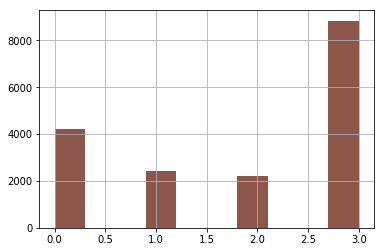

In [23]:
cat_model = Catb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

In [24]:
lgb_train=reduce_train.copy()
lgb_train.columns = lgb_train.columns.str.strip()     
lgb_train.columns = lgb_train.columns.str.replace(' ', '_')         
lgb_train.columns = lgb_train.columns.str.replace(r"[^a-zA-Z\d\_]+", "")    
lgb_train.columns = lgb_train.columns.str.replace(r"[^a-zA-Z\d\_]+", "")
#lgb_df_ts= ajusted_test.copy()
#lgb_df_ts.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in lgb_df_ts.columns]
lgb_model = Lgb_Model(lgb_train,ajusted_test, features, categoricals=categoricals)

KeyError: '[0, 1, 2050, 2, 4100, 3, \'Dino Drink\', 2060, 4110, \'Air Show\', 2070, 2075, 2080, 2081, 2083, \'acc_Bird Measurer (Assessment)\', 3110, 3120, 3121, \'Mushroom Sorter (Assessment)\', \'Flower Waterer (Activity)\', \'Magma Peak - Level 1\', \'Tree Top City - Level 2\', \'Balancing Act\', \'Chicken Balancer (Activity)\', "Pirate\'s Tale", \'Welcome to Lost Lagoon!\', \'Bug Measurer (Activity)\', 4220, \'Watering Hole (Activity)\', 4230, \'Chest Sorter (Assessment)\', \'Crystals Rule\', \'Crystal Caves - Level 3\', \'Egg Dropper (Activity)\', \'Costume Box\', \'Crystal Caves - Level 2\', \'Heavy, Heavier, Heaviest\', \'All Star Sorting\', \'acc_Chest Sorter (Assessment)\', \'Tree Top City - Level 1\', \'Scrub-A-Dub\', \'Sandcastle Builder (Activity)\', \'Crystal Caves - Level 1\', \'Bubble Bath\', \'Pan Balance\', \'12 Monkeys\', \'Treasure Map\', \'Honey Cake\', \'Dino Dive\', \'Tree Top City - Level 3\', \'Cart Balancer (Assessment)\', \'acc_Cauldron Filler (Assessment)\', \'Bird Measurer (Assessment)\', \'acc_Mushroom Sorter (Assessment)\', \'Magma Peak - Level 2\', \'Slop Problem\', \'Cauldron Filler (Assessment)\', \'Fireworks (Activity)\', \'Happy Camel\', 5000, \'Lifting Heavy Things\', \'Chow Time\', 4010, 4020, 4021, 4022, 4025, 4030, 4031, 4035, 4040, 4045, \'Ordering Spheres\', 2000, 4050, 2010, 2020, 4070, 2025, 4080, 2035, \'Leaf Leader\', 4090, 4095] not in index'

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-merror:0.318988	val-merror:0.398135
Multiple eval metrics have been passed: 'val-merror' will be used for early stopping.

Will train until val-merror hasn't improved in 100 rounds.
[100]	train-merror:0.257791	val-merror:0.370161
[200]	train-merror:0.226132	val-merror:0.369313
Stopping. Best iteration:
[106]	train-merror:0.255954	val-merror:0.367618

Partial score of fold 0 is: 0.19714878237172806
[0]	train-merror:0.307872	val-merror:0.396834
Multiple eval metrics have been passed: 'val-merror' will be used for early stopping.

Will train until val-merror hasn't improved in 100 rounds.
[100]	train-merror:0.25749	val-merror:0.368852
Stopping. Best iteration:
[78]	train-merror:0.262083	val-merror:0.36857

Partial score of fold 1 is: 0.18531888564467114
[0]	train-merror:0.307377	val-merror:0.406444
Multiple eval metrics have been passed: 'val-merror' will be used for early stopping.

Will train until val-merror hasn't improved in 100 rounds.
[100]	train-merror:0.252685	val-merro

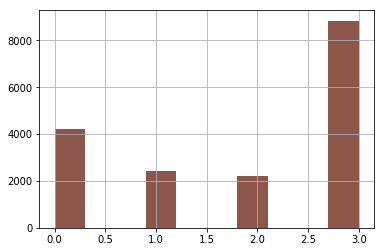

In [25]:
xgb_model = Xgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:100: DeprecationWarning: The ``active_features_`` attribute was deprecated in version 0.20 and will be removed 0.22.
  warnings.warn(msg, category=DeprecationWarning)


(17690, 370)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               74200     
_________________________________________________________________
layer_normalization (LayerNo (None, 200)               400       
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
layer_normalization_1 (Layer (None, 100)               200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)    

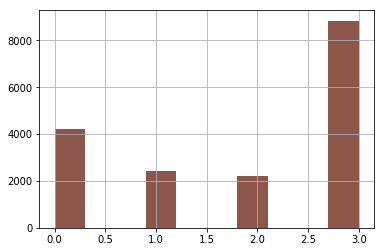

In [26]:
nn_model = Nn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

In [27]:
cnn_model = Cnn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:100: DeprecationWarning: The ``active_features_`` attribute was deprecated in version 0.20 and will be removed 0.22.
  warnings.warn(msg, category=DeprecationWarning)


(50, 370)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 370)]             0         
_________________________________________________________________
lambda (Lambda)              (None, 50, 370)           0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 370, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 7, 18)          45018     
_________________________________________________________________
flatten (Flatten)            (None, 126)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               12700     
_________________________________________________________________
layer_normalization_20 (Laye (None, 100)           

In [28]:
#random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
#rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
# Train the model on training data
rf.fit(reduce_train[features], reduce_train['accuracy_group'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [29]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(reduce_train[features],reduce_train['accuracy_group'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [30]:
m1=cat_model.export_model()
#m2=lgb_model.export_model()
m2=knn_clf
m3=xgb_model.export_model()
m4=nn_model.export_model()
m5=rf
m6=cnn_model.export_model()

In [31]:
tr1=m1.predict(reduce_train[features])
tr2=m2.predict(reduce_train[features])
tr3=m3.predict(xgb.DMatrix(reduce_train[features]))
tr5=m5.predict(reduce_train[features])

In [32]:
enc = OneHotEncoder()
train_cats = enc.fit_transform(reduce_train[categoricals])
t_df=pd.DataFrame(train_cats.toarray())
x = pd.concat([reduce_train[features], t_df], axis=1)
scalar = MinMaxScaler()
x[features] = scalar.fit_transform(x[features])
tr4=m4.predict(x)
tr6=m6.predict(x)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [33]:
#creat the test data set
ts1=m1.predict(reduce_test[features])
ts2=m2.predict(reduce_test[features])
ts3=m3.predict(xgb.DMatrix(reduce_test[features]))
ts5=m5.predict(reduce_test[features])
enc = OneHotEncoder()
train_cats = enc.fit_transform(reduce_test[categoricals])
t_df=pd.DataFrame(train_cats.toarray())
x = pd.concat([reduce_test[features], t_df], axis=1)
scalar = MinMaxScaler()
x[features] = scalar.fit_transform(x[features])
ts4=m4.predict(x)
ts6=m6.predict(x)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [34]:
#data stacking
stacking_predictions=np.column_stack((tr1,tr2,tr3,tr4,tr5,tr6))
stacking_test_predictions=np.column_stack((ts1,ts2,ts3,ts4,ts5,ts6))
tr_y=reduce_train['accuracy_group']
#data split up
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(stacking_predictions,tr_y, test_size=0.3)

In [35]:
#meta model creation
rf_meta=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rf_meta.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [36]:
f_pred=rf_meta.predict(X_test)
from sklearn.metrics import accuracy_score,cohen_kappa_score
print("Meta- Accuracy",accuracy_score(Y_test,f_pred))
print("Meta- Kappa",cohen_kappa_score(f_pred,Y_test,weights='quadratic'))

Meta- Accuracy 0.7363859054079518
Meta- Kappa 0.6957363108145449


In [37]:
final_pred=rf_meta.predict(stacking_test_predictions)
print(final_pred.shape)

(1000,)


In [38]:
#weights = {'lbg': 0.60, 'cat': 0, 'xgb': 0.20, 'nn': 0.20}
#final_pred = (lgb_model.y_pred * weights['lbg']) + (xgb_model.y_pred * weights['xgb']) + (nn_model.y_pred * weights['nn'])
#final_pred = cnn_model.y_pred
#final_pred=rf_meta.predict(stacking_test_predictions)
#print(final_pred.shape)
final_pred
sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)

{0: 0.0, 1: 3.0, 2: 3.0}


3    0.675
0    0.261
1    0.049
2    0.015
Name: accuracy_group, dtype: float64

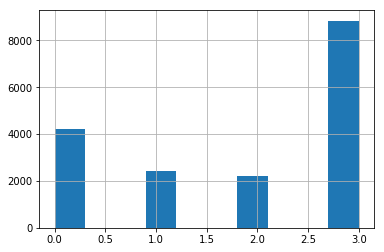

In [39]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))
sample_submission['accuracy_group'].value_counts(normalize=True)

In [40]:
final_pred 

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,

In [41]:
sample_submission['accuracy_group']

0      3
1      3
2      3
3      3
4      3
      ..
995    3
996    0
997    3
998    0
999    1
Name: accuracy_group, Length: 1000, dtype: int64